In [ ]:
!pip install umap-learn[plot]
!pip install hdbscan

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm
import requests
import os
import tarfile
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_rand_score as rand
import hdbscan

In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:56<00:00,  1.04it/s]


In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
print(num_features)

(3670, 4096) (3670,)
4096


In [ ]:
scipy.sparse.issparse(f_all)

False

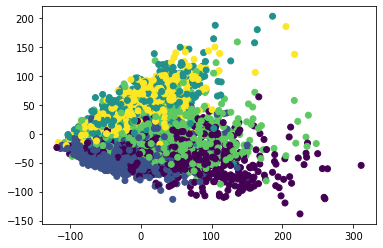

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# AUTOENCODER

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self.forward(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


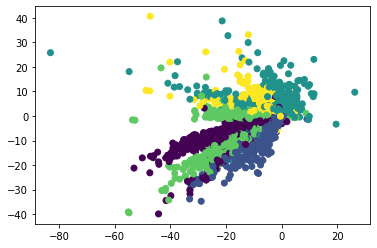

In [ ]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

# MULTILAYER PERCEPTRON

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(300)):
            for (X_, y_) in dataloader:
                X_ = X_.cuda()
                y_ = y_.cuda()
                optimizer.zero_grad()
                # ===================forward=====================
                output = self.forward(X_)
                loss = criterion(output, y_)
                # ===================backward====================
                loss.backward()
                optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
        total = 0
        correct = 0
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
        with torch.no_grad():
            for X_, y_ in dataloader:
                output = self.forward(X_)
                _, predicted = torch.max(output, 1)
                total += y_.size(0)
                correct += (predicted == y_).sum().item()
        return 100 * correct // total

# MLP ON ORIGINAL VGG FEATURES

In [ ]:
num_train = f_all.shape[0]
test_size = 0.1
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_indices, test_indices = indices[split:], indices[:split]

In [ ]:
X_train, y_train = f_all[train_indices], y_all[train_indices]
X_test, y_test = f_all[test_indices], y_all[test_indices]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3303, 4096) (3303,)
(367, 4096) (367,)


In [ ]:
net = MLP(num_features)
X_out = net.train(X_train, y_train)

100%|██████████| 300/300 [00:58<00:00,  5.10it/s]


In [ ]:
accuracy = net.eval(X_test, y_test)
print("{} %".format(accuracy))

94 %


# MLP ON REDUCED FEATURES

SVD

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

for val in r:   
    print("Computing Truncated SVD for r = " + str(val) + "...")
    lsi = TruncatedSVD(n_components=val)
    output = lsi.fit_transform(f_all)
    print("Training MLP for r = " + str(val) + "...")
    X_train, y_train = output[train_indices], y_all[train_indices]
    X_test, y_test = output[test_indices], y_all[test_indices]
    num_features = output.shape[1]
    net = MLP(num_features)
    X_out = net.train(X_train, y_train)    
    print("Computing Accuracy for r = " + str(val) + "...")
    accuracy = net.eval(X_test, y_test)
    print("Accuracy = {}%".format(accuracy))
    print("---" * 20)

Computing Truncated SVD for r = 1...
Training MLP for r = 1...


100%|██████████| 300/300 [00:32<00:00,  9.25it/s]


Computing Accuracy for r = 1...
Accuracy = 24%
------------------------------------------------------------
Computing Truncated SVD for r = 2...
Training MLP for r = 2...


100%|██████████| 300/300 [00:25<00:00, 11.62it/s]


Computing Accuracy for r = 2...
Accuracy = 54%
------------------------------------------------------------
Computing Truncated SVD for r = 3...
Training MLP for r = 3...


100%|██████████| 300/300 [00:37<00:00,  7.97it/s]


Computing Accuracy for r = 3...
Accuracy = 61%
------------------------------------------------------------
Computing Truncated SVD for r = 5...
Training MLP for r = 5...


100%|██████████| 300/300 [00:32<00:00,  9.34it/s]


Computing Accuracy for r = 5...
Accuracy = 69%
------------------------------------------------------------
Computing Truncated SVD for r = 10...
Training MLP for r = 10...


100%|██████████| 300/300 [00:27<00:00, 10.82it/s]


Computing Accuracy for r = 10...
Accuracy = 87%
------------------------------------------------------------
Computing Truncated SVD for r = 20...
Training MLP for r = 20...


100%|██████████| 300/300 [00:31<00:00,  9.44it/s]


Computing Accuracy for r = 20...
Accuracy = 91%
------------------------------------------------------------
Computing Truncated SVD for r = 50...
Training MLP for r = 50...


100%|██████████| 300/300 [00:26<00:00, 11.43it/s]


Computing Accuracy for r = 50...
Accuracy = 94%
------------------------------------------------------------
Computing Truncated SVD for r = 100...
Training MLP for r = 100...


100%|██████████| 300/300 [00:27<00:00, 11.09it/s]


Computing Accuracy for r = 100...
Accuracy = 94%
------------------------------------------------------------
Computing Truncated SVD for r = 300...
Training MLP for r = 300...


100%|██████████| 300/300 [00:26<00:00, 11.31it/s]

Computing Accuracy for r = 300...
Accuracy = 91%
------------------------------------------------------------


UMAP

In [ ]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

for val in r:   
    print("Computing UMAP for r = " + str(val) + "...")
    reducer = umap.UMAP(n_components=val, metric="cosine")
    output = reducer.fit_transform(f_all)
    print("Training MLP for r = " + str(val) + "...")
    X_train, y_train = output[train_indices], y_all[train_indices]
    X_test, y_test = output[test_indices], y_all[test_indices]
    num_features = output.shape[1]
    net = MLP(num_features)
    X_out = net.train(X_train, y_train)    
    print("Computing Accuracy for r = " + str(val) + "...")
    accuracy = net.eval(X_test, y_test)
    print("Accuracy = {}%".format(accuracy))
    print("---" * 20)

Computing UMAP for r = 1...


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Training MLP for r = 1...


100%|██████████| 300/300 [00:26<00:00, 11.39it/s]


Computing Accuracy for r = 1...
Accuracy = 83%
------------------------------------------------------------
Computing UMAP for r = 2...
Training MLP for r = 2...


100%|██████████| 300/300 [00:26<00:00, 11.46it/s]


Computing Accuracy for r = 2...
Accuracy = 85%
------------------------------------------------------------
Computing UMAP for r = 3...
Training MLP for r = 3...


100%|██████████| 300/300 [00:25<00:00, 11.90it/s]


Computing Accuracy for r = 3...
Accuracy = 86%
------------------------------------------------------------
Computing UMAP for r = 5...
Training MLP for r = 5...


100%|██████████| 300/300 [00:25<00:00, 11.71it/s]


Computing Accuracy for r = 5...
Accuracy = 88%
------------------------------------------------------------
Computing UMAP for r = 10...
Training MLP for r = 10...


100%|██████████| 300/300 [00:25<00:00, 11.67it/s]


Computing Accuracy for r = 10...
Accuracy = 86%
------------------------------------------------------------
Computing UMAP for r = 20...
Training MLP for r = 20...


100%|██████████| 300/300 [00:25<00:00, 11.78it/s]


Computing Accuracy for r = 20...
Accuracy = 84%
------------------------------------------------------------
Computing UMAP for r = 50...
Training MLP for r = 50...


100%|██████████| 300/300 [00:25<00:00, 11.71it/s]


Computing Accuracy for r = 50...
Accuracy = 85%
------------------------------------------------------------
Computing UMAP for r = 100...
Training MLP for r = 100...


100%|██████████| 300/300 [00:25<00:00, 11.65it/s]


Computing Accuracy for r = 100...
Accuracy = 84%
------------------------------------------------------------
Computing UMAP for r = 300...
Training MLP for r = 300...


100%|██████████| 300/300 [00:26<00:00, 11.33it/s]

Computing Accuracy for r = 300...
Accuracy = 82%
------------------------------------------------------------


##t-SNE

In [ ]:
import seaborn as sns
def tsne(training_data, training_labels):
    model = TSNE().fit_transform(training_data)
    sns.scatterplot(model[:,0], model[:,1], hue = training_labels, legend = 'full')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


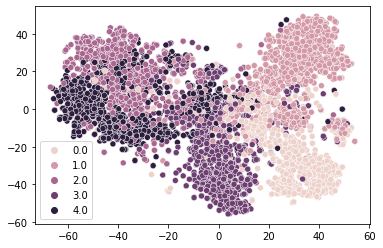

In [ ]:
tsne(f_all, y_all)

##Module Performance

In [ ]:
def performance(training_data, training_labels, scores, hdbscan_param, hyper=50, clusters=5, cluster_selection_epsilon=0.5, D_reduction_method='SVD', cluster_method='KMeans'):
    if D_reduction_method == 'SVD':
        model = PCA(n_components=hyper).fit_transform(training_data)
    elif D_reduction_method == 'UMAP':
        model = umap.UMAP(n_components=hyper, metric="cosine").fit_transform(training_data)
    elif D_reduction_method == 'AUTO':
        model = Autoencoder(n_components=hyper).fit_transform(training_data)
    elif D_reduction_method == None:
        model = training_data
    if cluster_method == 'KMeans':
        cluster = KMeans(init='k-means++', n_clusters=clusters, random_state=0, max_iter=1000, n_init=500).fit(model)
    elif cluster_method == 'Agglomerative':
        cluster = AgglomerativeClustering(n_clusters=clusters, linkage="ward").fit(model)
    elif cluster_method == 'HDBSCAN':
        cluster = hdbscan.HDBSCAN(min_cluster_size=hdbscan_param[0], cluster_selection_epsilon=hdbscan_param[1], min_samples=hdbscan_param[2]).fit(model)
    score = rand(training_labels, cluster.labels_)
    scores.append(score)
    print('The rand score for dimensionality reduction method = {} and clustering method = {} is {}'.format(D_reduction_method, cluster_method, score))

In [ ]:
temp = PCA(n_components=50).fit_transform(f_all)
best_cluster_selection_epsilon  = 0
best_min_samples = 0
best_min_cluster_size = 0
best_score = 0
params = []
for cluster_selection_epsilon in (0.5, 5):
    for min_samples in list(range(5, 100, 5)):
        for min_cluster_size in range(2, 10):
            cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon, min_samples=min_samples).fit(temp)
            mean_score = rand(y_all, cluster.labels_)
            if mean_score > best_score:
                best_score = mean_score
                best_cluster_selection_epsilon = cluster_selection_epsilon
                best_min_samples = min_samples
                best_min_cluster_size = min_cluster_size
params.append(best_min_cluster_size)
params.append(best_cluster_selection_epsilon)
params.append(best_min_samples)

In [ ]:
print(params)

[3, 0.5, 5]


In [ ]:
scores = []
D_reduction_methods = [None, 'SVD', 'UMAP', 'AUTO']
cluster_methods = ['KMeans', 'Agglomerative', 'HDBSCAN']
for d_method in D_reduction_methods:
    for c_method in cluster_methods:
        performance(f_all, y_all, scores, hdbscan_param=params, D_reduction_method=d_method, cluster_method=c_method)

The rand score for dimensionality reduction method = None and clustering method = KMeans is 0.1901365675300198
The rand score for dimensionality reduction method = None and clustering method = Agglomerative is 0.18855278251971858
The rand score for dimensionality reduction method = None and clustering method = HDBSCAN is 0.0024065502160805084
The rand score for dimensionality reduction method = SVD and clustering method = KMeans is 0.19303110830958886
The rand score for dimensionality reduction method = SVD and clustering method = Agglomerative is 0.18522358052211976
The rand score for dimensionality reduction method = SVD and clustering method = HDBSCAN is 0.016163188916860492
The rand score for dimensionality reduction method = UMAP and clustering method = KMeans is 0.46356035800630996
The rand score for dimensionality reduction method = UMAP and clustering method = Agglomerative is 0.4682643306519372
The rand score for dimensionality reduction method = UMAP and clustering method = H

100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


The rand score for dimensionality reduction method = AUTO and clustering method = KMeans is 0.1788383559277152


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


The rand score for dimensionality reduction method = AUTO and clustering method = Agglomerative is 0.24470485161333744


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


The rand score for dimensionality reduction method = AUTO and clustering method = HDBSCAN is 0.012101805335357221
